## Imports, Classes, and Constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import concurrent.futures
import time

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.base import clone

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

RANDOM_SEED = 42

class StemCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemCountVectorizer, self).build_analyzer()
        
        return lambda document: ([SnowballStemmer('english', ignore_stopwords=True).stem(word) for word in analyzer(document)])

## Dataset Preprocessing

In [2]:
mcu_subset = pd.read_csv("./data/mcu_subset.csv")

np.random.seed(RANDOM_SEED)
mcu_subset = mcu_subset.reindex(np.random.permutation(mcu_subset.index))

mcu_subset.head()

,Unnamed: 0,character,line,movie,year,words,Adam McKay,Anna Boden,Art Marcum,Ashley Edward Miller,...,Joss Whedon,Justin Theroux,Mark Fergus,Matt Holloway,Paul Rudd,Ryan Coogler,Ryan Fleck,Shane Black,Stephen McFeely,Zack Stentz
1263,2218,THOR,"Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?",Thor,2011,15,False,False,False,True,...,False,False,False,False,False,False,False,False,False,True
3951,7527,THOR,They'll try to leave the city.,Avengers: Age of Ultron,2015,6,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4198,8890,TONY STARK,"Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",Captain America: Civil War,2016,15,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6078,14843,BRUCE BANNER,It was worse for me. Because I lost twice. First Hulk lost. Then Banner lost. Then we all lost.,Avengers: Endgame,2019,23,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
96,141,TONY STARK,"Okay, here’s what I need... S-Category missiles. Lot 7043. The S-30 explosive tritonal. And a dozen of the S-76. Mortars: M-Category #1, 4, 8, 20, and 60. M- 229’s, I need eleven of these. Mines: the pre-90s AP 5s and AP 16s.",Iron Man,2008,49,False,False,True,False,...,False,False,True,True,False,False,False,False,False,False


In [3]:
pd.DataFrame(mcu_subset['character'].value_counts())

,character
TONY STARK,1788
STEVE ROGERS,977
THOR,863
PETER PARKER,551
NATASHA ROMANOFF,498
PEPPER POTTS,442
BRUCE BANNER,379
NICK FURY,366
LOKI,327
JAMES RHODES,318


In [4]:
y = mcu_subset["character"].to_numpy().astype(str)
X = mcu_subset["line"].to_numpy().astype(str)

X[0:10], y[0:10]

(array(['Stay here. Once I have Mjolnir, I will return what they stole from you. Deal?',
        "They'll try to leave the city.",
        "Oh, yeah. It'd be great if we had a Hulk right about now. Any shot?",
        'It was worse for me.  Because I lost twice.  First Hulk lost.  Then Banner lost.  Then we all lost.',
        'Okay, here’s what I need... S-Category missiles.  Lot 7043.  The S-30 explosive tritonal.  And a dozen of the S-76.  Mortars: M-Category #1, 4, 8, 20, and 60.  M- 229’s, I need eleven of these.  Mines: the pre-90s AP 5s and AP 16s. ',
        'A little.',
        "You really think I'd need one? My wife kicked me out.",
        'Is this is a test?', 'What about Ultron himself?',
        'Who put me there? Who put me there?!'], dtype='<U1388'),
 array(['THOR', 'THOR', 'TONY STARK', 'BRUCE BANNER', 'TONY STARK',
        'STEVE ROGERS', 'NICK FURY', 'STEVE ROGERS', 'STEVE ROGERS',
        'LOKI'], dtype='<U16'))

## Wholistic Model (Model 14)

In [5]:
cross_validator = StratifiedKFold(n_splits=100, random_state=RANDOM_SEED, shuffle=True)
score_method = "balanced_accuracy"

In [6]:
class OVR_Model(BaseEstimator):
    '''
    Trains a different model for each label that predits
    'LABEL' and 'NOT LABEL'.  Prediction creates probabilities
    for each 'LABEL' and returns the label with the highest probability
    '''
    def __init__(self, base_model):
        self.base_model = base_model
        self.models = []
        self.classes_ = []
        
    def fit(self, X, y, verbose=False):
        
        self.classes_ = np.unique(y)
        
        def train_model(X,y,label):
            if verbose:
                import warnings
                warnings.simplefilter('always')
                warnings.warn("Training a model model '" + label + "'")
                start = time.time()
            
            binary_y = (y == np.full(y.shape, label))
            new_model = clone(self.base_model)
            new_model.fit(X, binary_y)
            
            return new_model
            
            if verbose:
                end = time.time()
                warnings.warn("Finished training model '" + label + "'.  Elapsed time: " + str(end-start) + "s")
                
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for label in self.classes_:
                futures.append(executor.submit(train_model, X, y, label))
                
            for i in range(0,len(futures)):
                try:
                    new_model = futures[i].result()
                    self.models.append(new_model)
                except Exception as exc:
                    print('Training %r generated an exception: %s' % (self.classes_[i], exc))            
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]
        
    def predict_proba(self, X, verbose=False):
        probabilities = np.empty(shape=(len(X), 0))
                                 
        def predict_proba_model(model,x):
            if verbose:
                import warnings
                warnings.simplefilter('always')
                warnings.warn("Predicting using model '" + label + "'")
                start = time.time()
                                 
            label_probs = model.predict_proba(x)[:, list(model.classes_).index(True)]
            
            if verbose:
                end = time.time()
                warnings.warn("Finished predicting using model '" + label + "'.  Elapsed time: " + str(end-start) + "s")
                                 
            return label_probs
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
            futures = []
            for model in self.models:
                futures.append(executor.submit(predict_proba_model, model, X))
                
            for i in range(0,len(futures)):
                try:
                    label_probs = futures[i].result()
                except Exception as exc:
                    print('Exception Generated: %s' % (exc))
                else:
                    probabilities = np.concatenate((probabilities, np.expand_dims(label_probs, axis=1)), axis=1)
         
        return probabilities
        

In [7]:
base_model = Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

model_14 = OVR_Model(base_model)

### Nested CV Balanced Accuracy

In [8]:
models = {"model_14": model_14}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    results = cross_val_score(model, X, y, cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 66.2min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 70.0min finished


,model_14
fold,
0,0.100000
1,0.143333
2,0.065000
3,0.053333
4,0.198333
5,0.131667
6,0.106667
7,0.095000
8,0.056111


### Confusion Matrix

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 67.7min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 72.7min finished


Balanced Accuracy: 0.30439977092213294
Balanced Accuracy: 0.30439977092213294


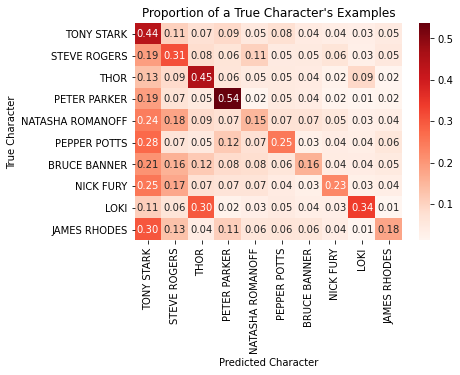

In [9]:
yhat = cross_val_predict(model_14, X, y, cv=cross_validator, n_jobs=-1, verbose=6)

main_characters = mcu_subset['character'].value_counts().index.to_numpy()

conf_matrix = pd.DataFrame(metrics.confusion_matrix(y, yhat, labels=main_characters))
normalized_conf_matrix = conf_matrix.div(conf_matrix.sum(axis=1), axis=0)
normalized_conf_matrix.columns = pd.Series(main_characters, name="Predicted Character")
normalized_conf_matrix.index = pd.Series(main_characters, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(normalized_conf_matrix)))

## Individual Character Models

In [10]:
def binarize_labels(y, label):
        binarized_y = np.copy(y)
        binarized_y = binarized_y.astype('object')
        binarized_y[np.argwhere(binarized_y != label)] = 'NOT ' + label
        return binarized_y

class Individual_Character_Model(BaseEstimator):
    '''
    Just a wrapper class to hold a label for a given character
    '''
    def __init__(self, label, base_model):
        self.label = label
        self.base_model = base_model
        self.model = None
        self.classes_ = [label, 'NOT ' + label]
        
    def fit(self,X,y):
        self.model = clone(self.base_model)
        self.model.fit(X, y)
        
    def predict(self,X):
        return self.model.predict(X)
        

In [11]:
base_model = Pipeline(steps=[('vect', StemCountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=False))])

tony_model = Individual_Character_Model('TONY STARK', base_model)
steve_model = Individual_Character_Model('STEVE ROGERS', base_model)
thor_model = Individual_Character_Model('THOR', base_model)
peter_model = Individual_Character_Model('PETER PARKER', base_model)
natasha_model = Individual_Character_Model('NATASHA ROMANOFF', base_model)
pepper_model = Individual_Character_Model('PEPPER POTTS', base_model)
bruce_model = Individual_Character_Model('BRUCE BANNER', base_model)
fury_model = Individual_Character_Model('NICK FURY', base_model)
loki_model = Individual_Character_Model('LOKI', base_model)
james_model = Individual_Character_Model('JAMES RHODES', base_model)

### Nested CV Balanced Accuracy

In [12]:
models = {"tony_model": tony_model, "steve_model": steve_model, "thor_model": thor_model, "peter_model": peter_model,
         "natasha_model": natasha_model, "pepper_model": pepper_model, "bruce_model": bruce_model, 
          "fury_model": fury_model, "loki_model": loki_model, "james_model": james_model}

cv_score_table = pd.DataFrame()

for name, model in models.items():
    print("Scoring model:", name)
    
    results = cross_val_score(model, X, binarize_labels(y, model.label), cv=cross_validator, scoring=score_method, n_jobs=-1, verbose=6)
    cv_score_table.insert(len(cv_score_table.columns), name, results, True)

cv_score_table.index.name = "fold"
cv_score_table.loc["mean"] = cv_score_table.mean()
cv_score_table.loc["std"] = cv_score_table.std()
cv_score_table.loc["max"] = cv_score_table.max()

cv_score_table

Scoring model: tony_model


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.7min remaining:   41.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: steve_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 11.5min remaining:   43.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: thor_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.4min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: peter_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.4min remaining:   39.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: natasha_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.4min remaining:   39.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: pepper_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 11.3min remaining:   43.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: bruce_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.3min remaining:   39.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: fury_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 11.2min remaining:   42.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: loki_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.4min remaining:   39.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Scoring model: james_model


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.4min remaining:   39.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


,tony_model,steve_model,thor_model,peter_model,natasha_model,pepper_model,bruce_model,fury_model,loki_model,james_model
fold,,,,,,,,,,
0,0.559028,0.632143,0.763158,0.783333,0.534426,0.691803,0.427419,0.600806,0.467742,0.552419
1,0.559028,0.510714,0.643275,0.583333,0.450820,0.859016,0.608871,0.592742,0.733871,0.584677
2,0.729167,0.625000,0.634503,0.516667,0.542623,0.642623,0.475806,0.701613,0.866935,0.576613
3,0.520833,0.496429,0.570175,0.758333,0.575410,0.609836,0.717742,0.451613,0.568548,0.600806
4,0.701389,0.814286,0.549708,0.658333,0.734426,0.426230,0.584677,0.560484,0.834677,0.443548
5,0.656250,0.592857,0.763158,0.858333,0.393443,0.550820,0.568548,0.451613,0.435484,0.451613
6,0.527778,0.551786,0.593567,0.683333,0.742623,0.493443,0.685484,0.592742,0.802419,0.584677
7,0.534722,0.637500,0.476608,0.758333,0.475410,0.542623,0.592742,0.733871,0.725806,0.725806
8,0.680556,0.616071,0.485380,0.791667,0.459016,0.567213,0.467742,0.725806,0.576613,0.592742


Peter Parker performs the best, which is more evidence that he is the most unique character.  See the MCU Insights notebook for more on this topic.

### Confusion Matricies

#### Tony Stark

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.4min remaining:   39.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished


Balanced Accuracy: 0.6053205677711135
Balanced Accuracy: 0.6053205677711135


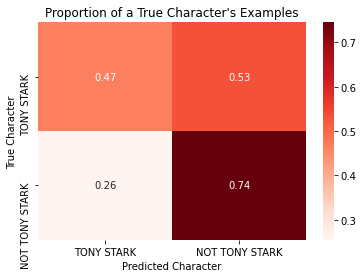

In [13]:
y_tony = binarize_labels(y, tony_model.label)
yhat = cross_val_predict(tony_model, X, y_tony, cv=cross_validator, n_jobs=-1, verbose=6)

tony_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_tony, yhat, labels=tony_model.classes_))
tony_normalized_conf_matrix = tony_conf_matrix.div(tony_conf_matrix.sum(axis=1), axis=0)
tony_normalized_conf_matrix.columns = pd.Series(tony_model.classes_, name="Predicted Character")
tony_normalized_conf_matrix.index = pd.Series(tony_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(tony_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_tony,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(tony_normalized_conf_matrix)))

#### Steve Rogers

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.6min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.6min finished


Balanced Accuracy: 0.6178548221531968
Balanced Accuracy: 0.6178548221531968


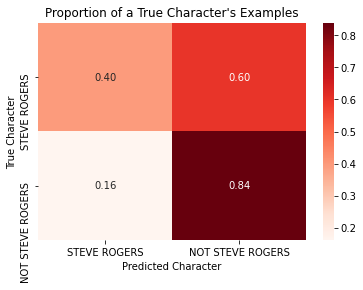

In [14]:
y_steve = binarize_labels(y, steve_model.label)
yhat = cross_val_predict(steve_model, X, y_steve, cv=cross_validator, n_jobs=-1, verbose=6)

steve_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_steve, yhat, labels=steve_model.classes_))
steve_normalized_conf_matrix = steve_conf_matrix.div(steve_conf_matrix.sum(axis=1), axis=0)
steve_normalized_conf_matrix.columns = pd.Series(steve_model.classes_, name="Predicted Character")
steve_normalized_conf_matrix.index = pd.Series(steve_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(steve_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_steve,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(steve_normalized_conf_matrix)))

#### Thor

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.5min remaining:   40.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


Balanced Accuracy: 0.6847715483926314
Balanced Accuracy: 0.6847715483926314


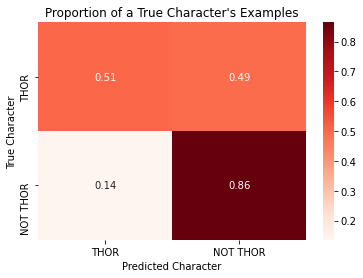

In [15]:
y_thor = binarize_labels(y, thor_model.label)
yhat = cross_val_predict(thor_model, X, y_thor, cv=cross_validator, n_jobs=-1, verbose=6)

thor_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_thor, yhat, labels=thor_model.classes_))
thor_normalized_conf_matrix = thor_conf_matrix.div(thor_conf_matrix.sum(axis=1), axis=0)
thor_normalized_conf_matrix.columns = pd.Series(thor_model.classes_, name="Predicted Character")
thor_normalized_conf_matrix.index = pd.Series(thor_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(thor_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_thor,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(thor_normalized_conf_matrix)))

#### Peter Parker

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.5min remaining:   40.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


Balanced Accuracy: 0.732108729649592
Balanced Accuracy: 0.732108729649592


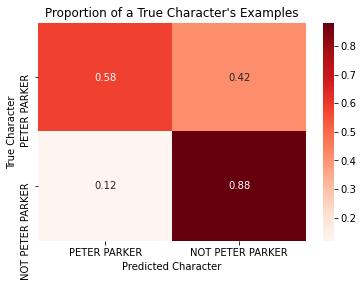

In [16]:
y_peter = binarize_labels(y, peter_model.label)
yhat = cross_val_predict(peter_model, X, y_peter, cv=cross_validator, n_jobs=-1, verbose=6)

peter_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_peter, yhat, labels=peter_model.classes_))
peter_normalized_conf_matrix = peter_conf_matrix.div(peter_conf_matrix.sum(axis=1), axis=0)
peter_normalized_conf_matrix.columns = pd.Series(peter_model.classes_, name="Predicted Character")
peter_normalized_conf_matrix.index = pd.Series(peter_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(peter_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_peter,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(peter_normalized_conf_matrix)))

#### Natasha Romanoff

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.5min remaining:   40.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


Balanced Accuracy: 0.5478254725773832
Balanced Accuracy: 0.5478254725773832


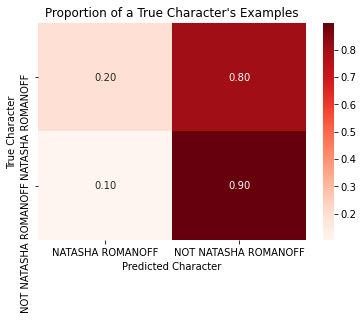

In [17]:
y_natasha = binarize_labels(y, natasha_model.label)
yhat = cross_val_predict(natasha_model, X, y_natasha, cv=cross_validator, n_jobs=-1, verbose=6)

natasha_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_natasha, yhat, labels=natasha_model.classes_))
natasha_normalized_conf_matrix = natasha_conf_matrix.div(natasha_conf_matrix.sum(axis=1), axis=0)
natasha_normalized_conf_matrix.columns = pd.Series(natasha_model.classes_, name="Predicted Character")
natasha_normalized_conf_matrix.index = pd.Series(natasha_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(natasha_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_natasha,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(natasha_normalized_conf_matrix)))

#### Pepper Potts

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.5min remaining:   40.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.5min finished


Balanced Accuracy: 0.6258307496902984
Balanced Accuracy: 0.6258307496902984


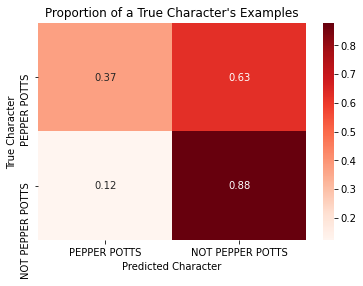

In [18]:
y_pepper = binarize_labels(y, pepper_model.label)
yhat = cross_val_predict(pepper_model, X, y_pepper, cv=cross_validator, n_jobs=-1, verbose=6)

pepper_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_pepper, yhat, labels=pepper_model.classes_))
pepper_normalized_conf_matrix = pepper_conf_matrix.div(pepper_conf_matrix.sum(axis=1), axis=0)
pepper_normalized_conf_matrix.columns = pd.Series(pepper_model.classes_, name="Predicted Character")
pepper_normalized_conf_matrix.index = pd.Series(pepper_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(pepper_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_pepper,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(pepper_normalized_conf_matrix)))

#### Bruce Banner

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.5min remaining:   40.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


Balanced Accuracy: 0.5781420153490554
Balanced Accuracy: 0.5781420153490554


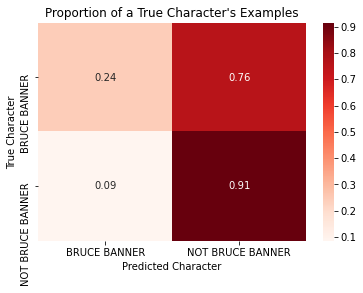

In [19]:
y_bruce = binarize_labels(y, bruce_model.label)
yhat = cross_val_predict(bruce_model, X, y_bruce, cv=cross_validator, n_jobs=-1, verbose=6)

bruce_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_bruce, yhat, labels=bruce_model.classes_))
bruce_normalized_conf_matrix = bruce_conf_matrix.div(bruce_conf_matrix.sum(axis=1), axis=0)
bruce_normalized_conf_matrix.columns = pd.Series(bruce_model.classes_, name="Predicted Character")
bruce_normalized_conf_matrix.index = pd.Series(bruce_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(bruce_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_bruce,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(bruce_normalized_conf_matrix)))

#### Nick Fury

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 10.6min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.6min finished


Balanced Accuracy: 0.594212480507824
Balanced Accuracy: 0.594212480507824


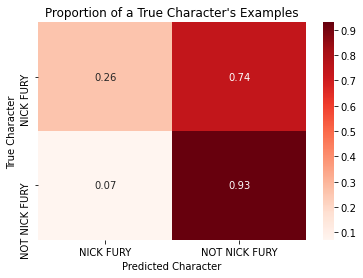

In [20]:
y_fury = binarize_labels(y, fury_model.label)
yhat = cross_val_predict(fury_model, X, y_fury, cv=cross_validator, n_jobs=-1, verbose=6)

fury_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_fury, yhat, labels=fury_model.classes_))
fury_normalized_conf_matrix = fury_conf_matrix.div(fury_conf_matrix.sum(axis=1), axis=0)
fury_normalized_conf_matrix.columns = pd.Series(fury_model.classes_, name="Predicted Character")
fury_normalized_conf_matrix.index = pd.Series(fury_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(fury_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_fury,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(fury_normalized_conf_matrix)))

#### Loki

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 11.3min remaining:   43.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.4min finished


Balanced Accuracy: 0.6793467668292181
Balanced Accuracy: 0.6793467668292181


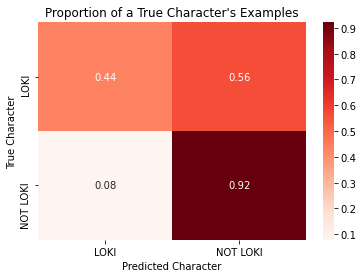

In [21]:
y_loki = binarize_labels(y, loki_model.label)
yhat = cross_val_predict(loki_model, X, y_loki, cv=cross_validator, n_jobs=-1, verbose=6)

loki_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_loki, yhat, labels=loki_model.classes_))
loki_normalized_conf_matrix = loki_conf_matrix.div(loki_conf_matrix.sum(axis=1), axis=0)
loki_normalized_conf_matrix.columns = pd.Series(loki_model.classes_, name="Predicted Character")
loki_normalized_conf_matrix.index = pd.Series(loki_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(loki_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_loki,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(loki_normalized_conf_matrix)))

#### James Rhodes

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  94 out of 100 | elapsed: 12.9min remaining:   49.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.9min finished


Balanced Accuracy: 0.5903591539351605
Balanced Accuracy: 0.5903591539351605


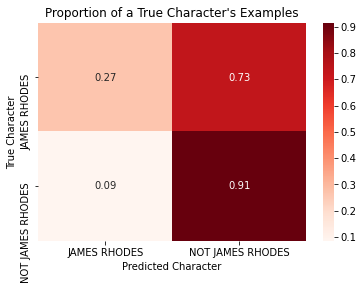

In [22]:
y_james = binarize_labels(y, james_model.label)
yhat = cross_val_predict(james_model, X, y_james, cv=cross_validator, n_jobs=-1, verbose=6)

james_conf_matrix = pd.DataFrame(metrics.confusion_matrix(y_james, yhat, labels=james_model.classes_))
james_normalized_conf_matrix = james_conf_matrix.div(james_conf_matrix.sum(axis=1), axis=0)
james_normalized_conf_matrix.columns = pd.Series(james_model.classes_, name="Predicted Character")
james_normalized_conf_matrix.index = pd.Series(james_model.classes_, name="True Character")

plt.title("Proportion of a True Character's Examples")
sns.heatmap(james_normalized_conf_matrix, annot=True, fmt='.2f', cmap=plt.cm.Reds)

# Should be the same
print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_james,yhat))
print("Balanced Accuracy:", np.mean(np.diagonal(james_normalized_conf_matrix)))

### Recalls

In [24]:
recalls = pd.DataFrame(columns=["recall"])

conf_matrices = [tony_normalized_conf_matrix, steve_normalized_conf_matrix, thor_normalized_conf_matrix,
                 peter_normalized_conf_matrix, natasha_normalized_conf_matrix, pepper_normalized_conf_matrix,
                 bruce_normalized_conf_matrix, fury_normalized_conf_matrix, loki_normalized_conf_matrix,
                 james_normalized_conf_matrix]

for conf_matrix in conf_matrices:
    recalls = recalls.append(pd.DataFrame(np.diagonal(conf_matrix.to_numpy()), 
                                          index=conf_matrix.index, columns=['recall']))

recalls.sort_values(by="recall", ascending=False, inplace=True)
recalls.loc['mean'] = recalls.mean()

recalls

,recall
NOT NICK FURY,0.928862
NOT LOKI,0.921385
NOT BRUCE BANNER,0.913540
NOT JAMES RHODES,0.913423
NOT NATASHA ROMANOFF,0.896856
NOT PETER PARKER,0.879825
NOT PEPPER POTTS,0.878358
NOT THOR,0.864329
NOT STEVE ROGERS,0.838576
NOT TONY STARK,0.744757
